In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
from os import path
import json
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib

plt.style.use("bmh")
matplotlib.rcParams['figure.figsize'] = (20.0, 7.0)

In [115]:
data_dir = "data"

train = pd.read_csv(path.join(data_dir, "train_input.csv"), sep=';', index_col=0)
ages = pd.read_csv(path.join(data_dir, "train_output.csv"), sep=';', index_col=0)

In [117]:
train_hypno = train["HYPNOGRAM"]

In [120]:
def get_hypno(row):
    hypno = pd.Series(literal_eval(row)).astype(np.int8)
    return hypno

In [121]:
train_hypno = train_hypno.apply(get_hypno)

In [125]:
# we replace the nan values (because the hypnograms don't have the same lengths) with -2 
# so they are not confused with -1 (missing values)
train_hypno.fillna(-2, inplace=True) 
# then we fill the missing values with the previous valid value
train_hypno.replace(-1, np.nan, inplace=True)
train_hypno.fillna(method="ffill", inplace=True)
# we reset -2 as nan
train_hypno.replace(-2, np.nan, inplace=True)

In [130]:
def get_duration_sleep(row):
    sleep = row.notnull().sum()
    return sleep*30

In [131]:
train["SLEEP_TIME"] = train_hypno.apply(get_duration_sleep, axis=1)

In [135]:
def get_duration_deep_sleep(row):
    deep_sleep = (row == 3).sum()
    return deep_sleep*30

In [136]:
train["DEEP_SLEEP_TIME"] = train_hypno.apply(get_duration_deep_sleep, axis=1)

In [140]:
def get_periods_deep_sleep(row):
    periods = []
    cnt = 1 * (row[0] == 3)
    for i in range(1, len(row)):
        if row[i] == 3:
            if row[i-1] != 3:
                cnt = 1
            else:
                cnt += 1
        else:
            if row[i-1] == 3:
                periods.append(cnt)
                cnt = 0
    if cnt > 0: periods.append(cnt)
    return pd.Series({"AVERAGE_DEEP_SLEEP": 30*np.mean(periods), "NUMBER_DEEP_SLEEP": len(periods)})

In [148]:
train = train.merge(train_hypno.apply(get_periods_deep_sleep, axis=1), left_index=True, right_index=True)

In [198]:
from public_MAPE import score_function
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split

In [190]:
data = train[["SLEEP_TIME", "DEEP_SLEEP_TIME", "AVERAGE_DEEP_SLEEP", "NUMBER_DEEP_SLEEP"]].values
ages = ages.values.ravel()

In [193]:
X_train, X_test, y_train, y_test = train_test_split(data, ages, test_size=0.3, random_state=42)

In [154]:
pca = PCA(n_components=2, random_state=42)
pca.fit(data, ages)
data_red = pca.transform(data, ages)

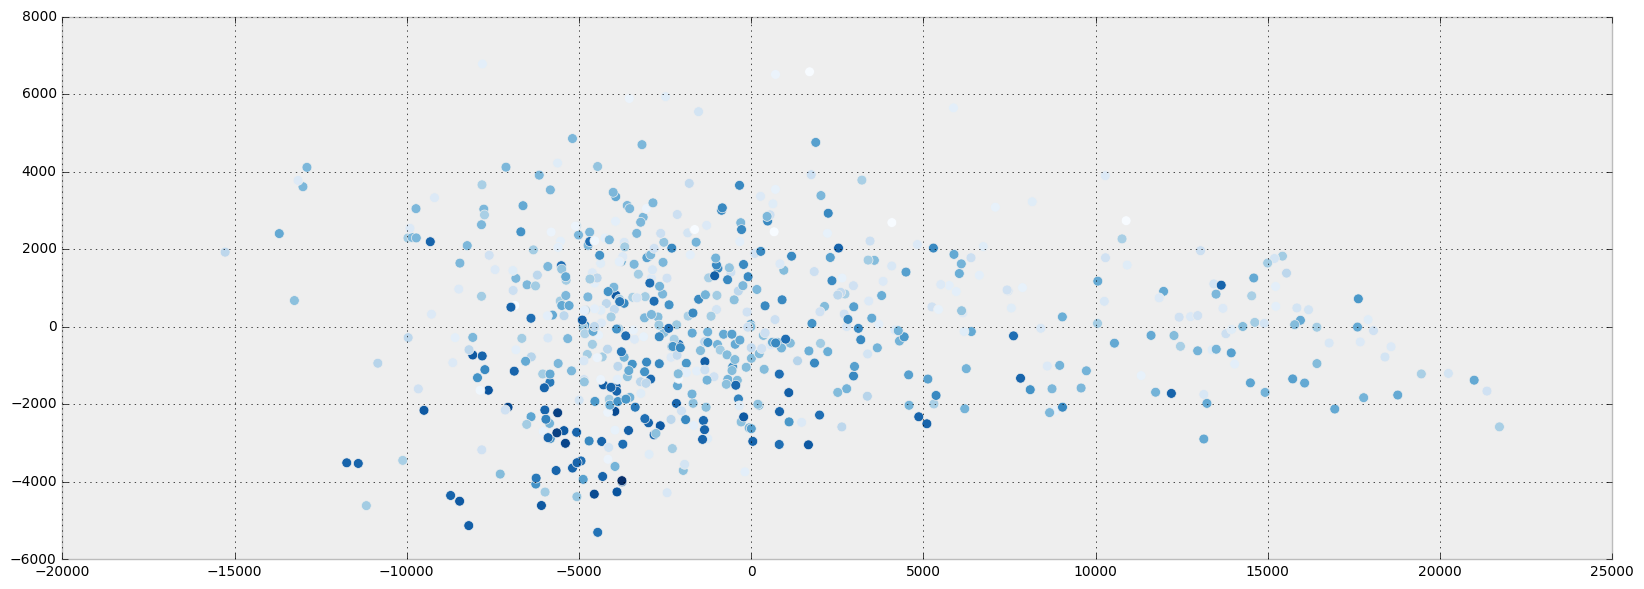

In [157]:
plt.scatter(data_red[:, 0], data_red[:, 1], s=50, c=ages, cmap=plt.get_cmap("Blues"))

In [199]:
reg = AdaBoostRegressor(random_state=42)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
score_function(y_test, pred)

27.863144706575238

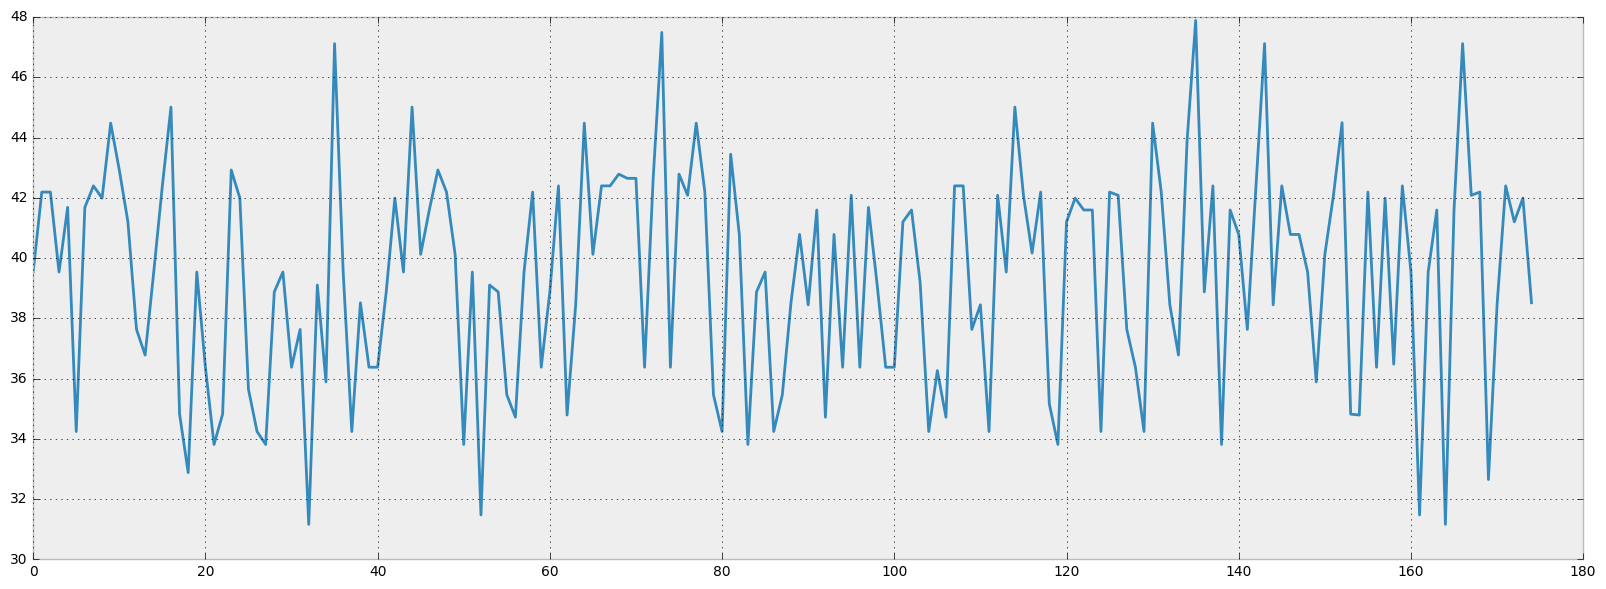

In [200]:
plt.plot(pred)
plt.show()